# aSPEM Experiment : analysis




TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%load_ext autoreload
%autoreload 2
#from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
exts = ['.png', '.svg', '.pdf']

In [3]:
%matplotlib inline
fig_width = 15
dpi = 400
from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [4]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [5]:
msfigpath = '../PasturelMontagniniPerrinet2019/figures'
#COLOR = ['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown', 'darkred','red']
list_sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']

nb_sujet = len(list_sujet)
COLOR = [(0+(1/nb_sujet)*n, 0, 0, 0.5) for n in range(nb_sujet)]

In [6]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

In [7]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

CS [0.15773933612004828, 0.07905694150420946, 0.0995267926383743, 0.15773933612004828, 0.1252968084068181, 0.019858205868107028, 0.007905694150420946, 0.024999999999999994, 0.07905694150420946, 0.1252968084068181, 0.1252968084068181] [0.01577393361200483, 0.19858205868107037, 0.15773933612004828, 0.19858205868107037, 0.15773933612004828, 0.25, 0.1252968084068181, 0.1252968084068181, 0.25, 0.1252968084068181, 0.0995267926383743]
RS [0.03962232981152784, 0.19858205868107037, 0.04988155787422198, 0.024999999999999994, 0.04988155787422198, 0.25, 0.03962232981152784, nan, nan, 0.19858205868107037, 0.019858205868107028] [0.25, 0.004988155787422195, nan, nan, nan, nan, 0.007905694150420946, 0.031473135294854175, 0.006279716078773948, 0.25, 0.15773933612004828]
SR [0.04988155787422198, 0.07905694150420946, 0.1252968084068181, 0.15773933612004828, 0.07905694150420946, 0.19858205868107037, 0.1252968084068181, 0.1252968084068181, 0.1252968084068181, 0.19858205868107037, 0.19858205868107037] [nan,

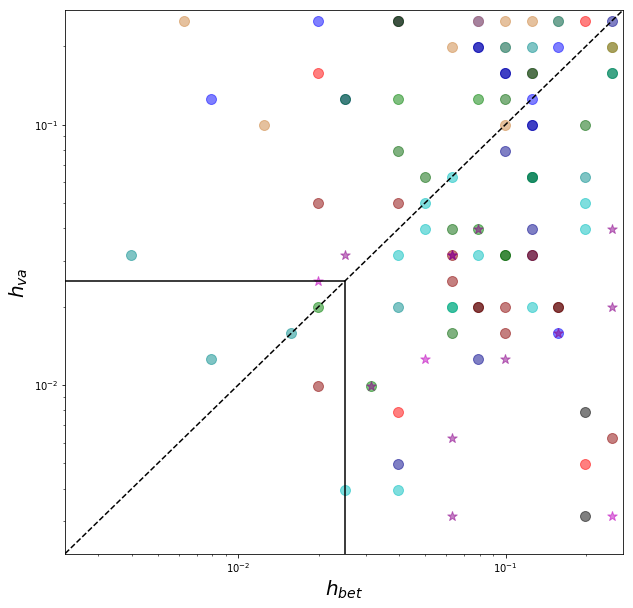

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,10))


Full = e.Full_list(modes_bcp=[])
modes_bcp = 'mean'
list_h = np.geomspace(0.0025, 0.25, 21)

COLOR = ['b', 'r', 'k', 'g', 'm', 'c',
         'darkblue', 'darkred', 'peru', 'darkgreen', 'darkmagenta', 'darkcyan']

for num, s in enumerate(set(Full.sujet)) :
    print(s, end=' ')
    va = Full['va'][Full.sujet==s].values.tolist()
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    r_va_100, r_bet_100 = [], []
    for c in range(0, 3*200-50, 50) : r_va_100.append([]) ; r_bet_100.append([])

    for h in list_h :

        for d, c in enumerate(range(0, 3*200-50, 50)) :
            x_100 = x[c:c+100]
            p_hat_100 = np.zeros(100)

            liste = [0, 50, 100]
            for a in range(len(liste)-1) :
                p_bar, r_bar, beliefs = bcp.inference(x_100[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                p_hat_100[liste[a]:liste[a+1]] = p_hat_p
            r_va_100[d].append(r_(p_hat_100.tolist(), va[c:c+100]))
            r_bet_100[d].append(r_(p_hat_100.tolist(), bet[c:c+100]))

    h_va_100, h_bet_100 = [], []
    for d, c in enumerate(range(0, 3*200-50, 50)) :
        h_va_100.append(list_h[np.argmax(r_va_100[d])] if np.argmax(r_va_100[d]) > 0.6 else np.nan)
        h_bet_100.append(list_h[np.argmax(r_bet_100[d])] if np.argmax(r_bet_100[d]) > 0.6 else np.nan)
    ax.scatter(h_va_100, h_bet_100, c=COLOR[num], alpha=0.5, s=100,
               marker='*' if s in ['AM', 'IP'] else None)
    
    print(h_va_100, h_bet_100)
    #proba = np.ma.masked_array(full_proba.values.tolist(), mask=np.isnan(full_result.values.tolist())).compressed()
    #data = np.ma.masked_array(full_result.values.tolist(), mask=np.isnan(full_result.values.tolist())).compressed()
    
ax.plot(np.arange(-10,10), np.arange(-10,10), '--k')
ax.vlines(0.025, 0, 0.025, colors='k')
ax.hlines(0.025, 0, 0.025, colors='k')
    
ax.set_xlabel('$h_{bet}$', fontsize=20) ; ax.set_xlim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
ax.set_ylabel('$h_{va}$', fontsize=20)  ; ax.set_ylim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
ax.set_xscale("log") ; ax.set_yscale("log")
plt.show()

In [9]:
for ext in exts: fig.savefig('{msfigpath}/5_inter-individual_differences_fit'.format(msfigpath=msfigpath) + ext, dpi=dpi)